In [1]:
import math
import os
import time
import sys
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn


#let's use cpu for now
context = mx.cpu()

# Test import, ignore

In [3]:
from NLP.src.training import training

# Create a sequence
We don't want the sequence to be completely random, otherwise the RNN won't be able to learn much

When we got a word sequence, we need to map each unique word to an integer and the integer sequence will be fed into the neural net

In [ ]:
input: txt file
output: dic1: integer -> word
        dic2: word -> integer
        seqence: integer sequence corresponding to the input txt

In [4]:
vocab_size = 50

x = mx.np.arange(vocab_size).as_nd_ndarray()
seq = mx.nd.tile(x, reps=2000)

In [5]:
seq


[ 0.  1.  2. ... 47. 48. 49.]
<NDArray 100000 @cpu(0)>

# DL portion

## RNN Model, we can modify this for more complex model structure

In [6]:
# bluntly stolen from https://gluon.mxnet.io/chapter05_recurrent-neural-networks/rnns-gluon.html
class RNNModel(gluon.Block):
    """A model with an encoder, recurrent layer, and a decoder."""

    def __init__(self, mode, vocab_size, num_embed, num_hidden,
                 num_layers, dropout=0.5, tie_weights=False, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            self.drop = nn.Dropout(dropout)
            self.encoder = nn.Embedding(vocab_size, num_embed,
                                        weight_initializer = mx.init.Uniform(0.1))
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(num_hidden, num_layers, activation='relu', dropout=dropout,
                                   input_size=num_embed)
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(num_hidden, num_layers, dropout=dropout,
                                   input_size=num_embed)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(num_hidden, num_layers, dropout=dropout,
                                    input_size=num_embed)
            elif mode == 'gru':
                self.rnn = rnn.GRU(num_hidden, num_layers, dropout=dropout,
                                   input_size=num_embed)
            else:
                raise ValueError("Invalid mode %s. Options are rnn_relu, "
                                 "rnn_tanh, lstm, and gru"%mode)
            if tie_weights:
                self.decoder = nn.Dense(vocab_size, in_units = num_hidden,
                                        params = self.encoder.params)
            else:
                self.decoder = nn.Dense(vocab_size, in_units = num_hidden)
            self.num_hidden = num_hidden

    def forward(self, inputs, hidden):
        emb = self.drop(self.encoder(inputs))
        #print(emb)
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

## training loop

### auxiliary functions

In [25]:
# change the data sequence to a batched sequence
def batchify(data, batch_size):
    """Reshape data into (num_example, batch_size)"""
    nbatch = data.shape[0] // batch_size
    data = data[:nbatch * batch_size]
    data = data.reshape((batch_size, nbatch)).T
    return data

def get_batch(source, i):
    data = source[i]
    target = source[i + 1]
    return data.reshape((1,len(data))), target.reshape((-1,))

# Compute loss from data_source and the current net
def eval(data_source):
    total_L = 0.0
    ntotal = 0
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = args_batch_size, ctx=context)
    for i in range(0, data_source.shape[0] - 1):
        data, target = get_batch(data_source, i)
        output, hidden = model(data, hidden)
        L = loss(output, target)
        total_L += mx.nd.sum(L).asscalar()
        ntotal += L.size
    return total_L / ntotal

In [26]:
x = batchify(seq, 32)
print('batchified data: ', x)
y = get_batch(x, 0)
print('first batch: ', y)

batchified data:  
[[ 0. 25.  0. ... 25.  0. 25.]
 [ 1. 26.  1. ... 26.  1. 26.]
 [ 2. 27.  2. ... 27.  2. 27.]
 ...
 [22. 47. 22. ... 47. 22. 47.]
 [23. 48. 23. ... 48. 23. 48.]
 [24. 49. 24. ... 49. 24. 49.]]
<NDArray 3125x32 @cpu(0)>
first batch:  (
[[ 0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.
   0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.  0. 25.]]
<NDArray 1x32 @cpu(0)>, 
[ 1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.
  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.  1. 26.]
<NDArray 32 @cpu(0)>)


### training loop

In [18]:
def train(train_data, args_epochs, args_batch_size, context, args_log_interval=10):
    loss_progress = []
    for epoch in range(args_epochs):
        total_L = 0.0
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = args_batch_size, ctx = context)
        for ibatch in range(0, train_data.shape[0] - 1):
            data, target = get_batch(train_data, ibatch)
            #need this to work, but it doesn't atm
            #hidden = detach(hidden)
            with autograd.record():
                output, hidden = model(data, hidden)
                L = loss(output, target)
                L.backward()

            trainer.step(args_batch_size)
            total_L += mx.nd.sum(L).asscalar()
            
        # print and record loss every epoch
        epoch_L = total_L / args_batch_size / ibatch
        print('[Epoch %d] loss %.2f' % (epoch + 1, epoch_L), end='\r')
        loss_progress.append(epoch_L)
        total_L = 0.0
        
    plt.plot(np.arange(args_epochs), loss_progress)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

## Prepare for training

In [19]:
#model constants
num_embed = 5
num_hidden = 5
num_layers = 1

#training constants
args_lr = 0.04
args_epochs = 30
args_batch_size = 32

In [20]:
train_data = batchify(seq, args_batch_size).as_in_context(context)

In [21]:
# define model and loss
# we do dropout=0 here to promote overfitting, on real data we might want a positive value
model = RNNModel(mode='lstm', vocab_size=vocab_size, num_embed=num_embed, num_hidden=num_hidden,
                 num_layers=num_layers, dropout=0)
model.collect_params().initialize(mx.init.Xavier(), ctx=context)
trainer = gluon.Trainer(model.collect_params(), 'sgd',
                        {'learning_rate': args_lr, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# Finally, train the RNN

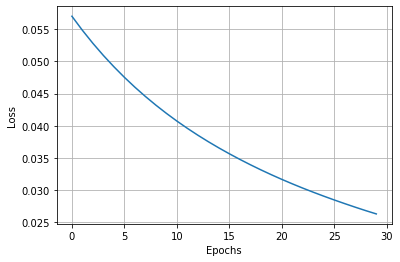

In [27]:
# finally train the model
train(train_data=train_data, args_epochs=args_epochs, args_batch_size=args_batch_size,
      context=context)

# Decoder, use the RNN we just learned to generate a sequence

## Here we just use a gready decoder, may do something fancier later

In [36]:
seed = mx.nd.array([[3]])
seq_length = 20

hidden = model.begin_state(func=mx.nd.zeros, batch_size=1, ctx=context)
output_seq = []
for i in range(seq_length):
    output, hidden = model(seed, hidden)
    seed = output.argmax().reshape((1,1))
    output_seq.append(seed[0].asscalar())

output_seq

[13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0]

# Auxiliary cells, don't read

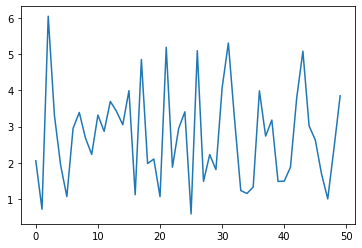

In [12]:
embed = model.encoder.weight.data()
norms = (embed**2).sum(axis = 1)
norms = norms.asnumpy()
plt.plot(np.arange(vocab_size), norms)

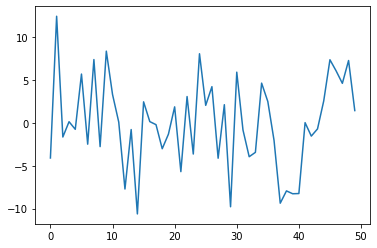

In [31]:
seed = mx.nd.array([[0]])
seq_length = 50

hidden = model.begin_state(func=mx.nd.zeros, batch_size=1, ctx=context)
output, hidden = model(seed, hidden)
plt.plot(np.arange(vocab_size), output[0].asnumpy())